In [2]:
import scvelo as scv

In [3]:
adata = scv.read("MacrophagesFiltered-CD_High_velo.h5ad")
adata

AnnData object with n_obs × n_vars = 4571 × 31053
    obs: 'orig.ident', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'nCount_ambiguous', 'nFeature_ambiguous', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.6', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters'
    var: 'features', 'ambiguous_features', 'spliced_features', 'unspliced_features'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [4]:
scv.pp.filter_and_normalize(adata, min_shared_counts = 20, n_top_genes = 2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 26584 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:22) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode = 'dynamical')
scv.tl.velocity_graph(adata)

recovering dynamics (using 1/16 cores)


  0%|          | 0/217 [00:00<?, ?gene/s]

    finished (0:01:54) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [6]:
clu_colors = ["#F8766D","#DB8E00","#AEA200","#64B200","#00BD5C","#00C1A7","#00BADE",
              "#00A6FF","#B385FF","#EF67EB","#FF63B6"]
adata.obs['clusters'] = adata.obs['RNA_snn_res.0.6']

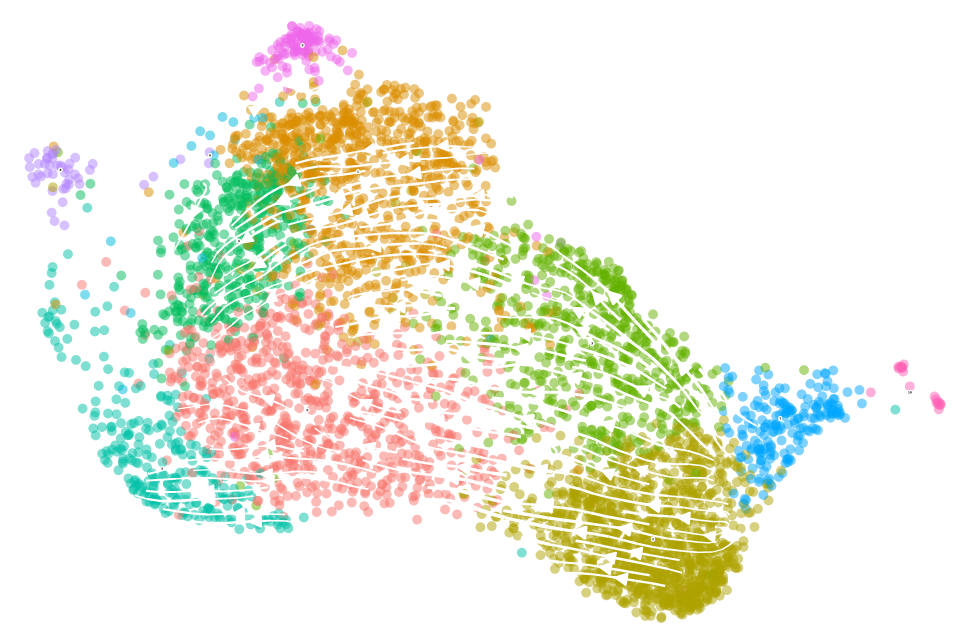

In [15]:
scv.pl.velocity_embedding_stream(adata, basis = 'umap', legend_fontsize = 0, title = '',
                                 color = "clusters", palette = clu_colors,
                                 dpi = 200, alpha = 0.5, size = 50, linewidth = 1, smooth = 0.3, min_mass = 4,
                                arrow_color="white")

In [7]:
scv.tl.rank_velocity_genes(adata, groupby='clusters', min_corr=.3)
df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head(10)

ranking velocity genes
    finished (0:00:02) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


0        1         2        3        4        5        6        7  \
0     Fcgr1      Vim     Stx11  Slc11a1  Plekho1      Mt1  Bcl2a1d      Fgr   
1    Slc7a2  S100a11     Ms4a7    Il1r2     Sod2  Tnfaip6   Clec4d      F10   
2    Metrnl  Plekho1     Oasl2    Oasl2  S100a11  Gm26917  Plekho1   Clec4e   
3   Tnfaip6   Clec4d       Gda    Fem1c  Bcl2a1d    Fcgr1      Vim     Emp3   
4   Gm26917     Sod2  Mir155hg  Emilin2   Samsn1     Actb     Sod2    Traf1   
5      Nos2   Gpr183    Ifi205    Sp140   Mycbp2    Prdx5      Rel    H2-M2   
6      Arg2    Rab7b   Trim30a    Ms4a7  Gm26917    Klrk1   Syngr1  Trim30a   
7  Dnase1l3  Bcl2a1d   Emilin2     Rtp4      Vim    Inhba   S100a6    Gpat3   
8       Rel   Mycbp2     H2-M2   S100a6     Arg1       C3    Rab7b    Ms4a7   
9    Samsn1      Rel     Anxa2    Runx1      Rel     Nos2    Ptafr   Rnf149   

         8        9             10  
0    H3f3b      Vim            F10  
1       C3  S100a11          Traf1  
2  Cd300lf  Bcl2a1d        Trim30a  
3  Trim30a  Plekho1           Mdm2  
4  Herpud1    Ccl24            Mt1  
5  Plekho1   Clec4d          Iigp1  
6     Slpi     Sod2  2310022A10Rik  
7   Metrnl   Samsn1          Ms4a7  
8    Ccl24    C3ar1          Gpat3  
9    Rsad2      Rel          Acer3

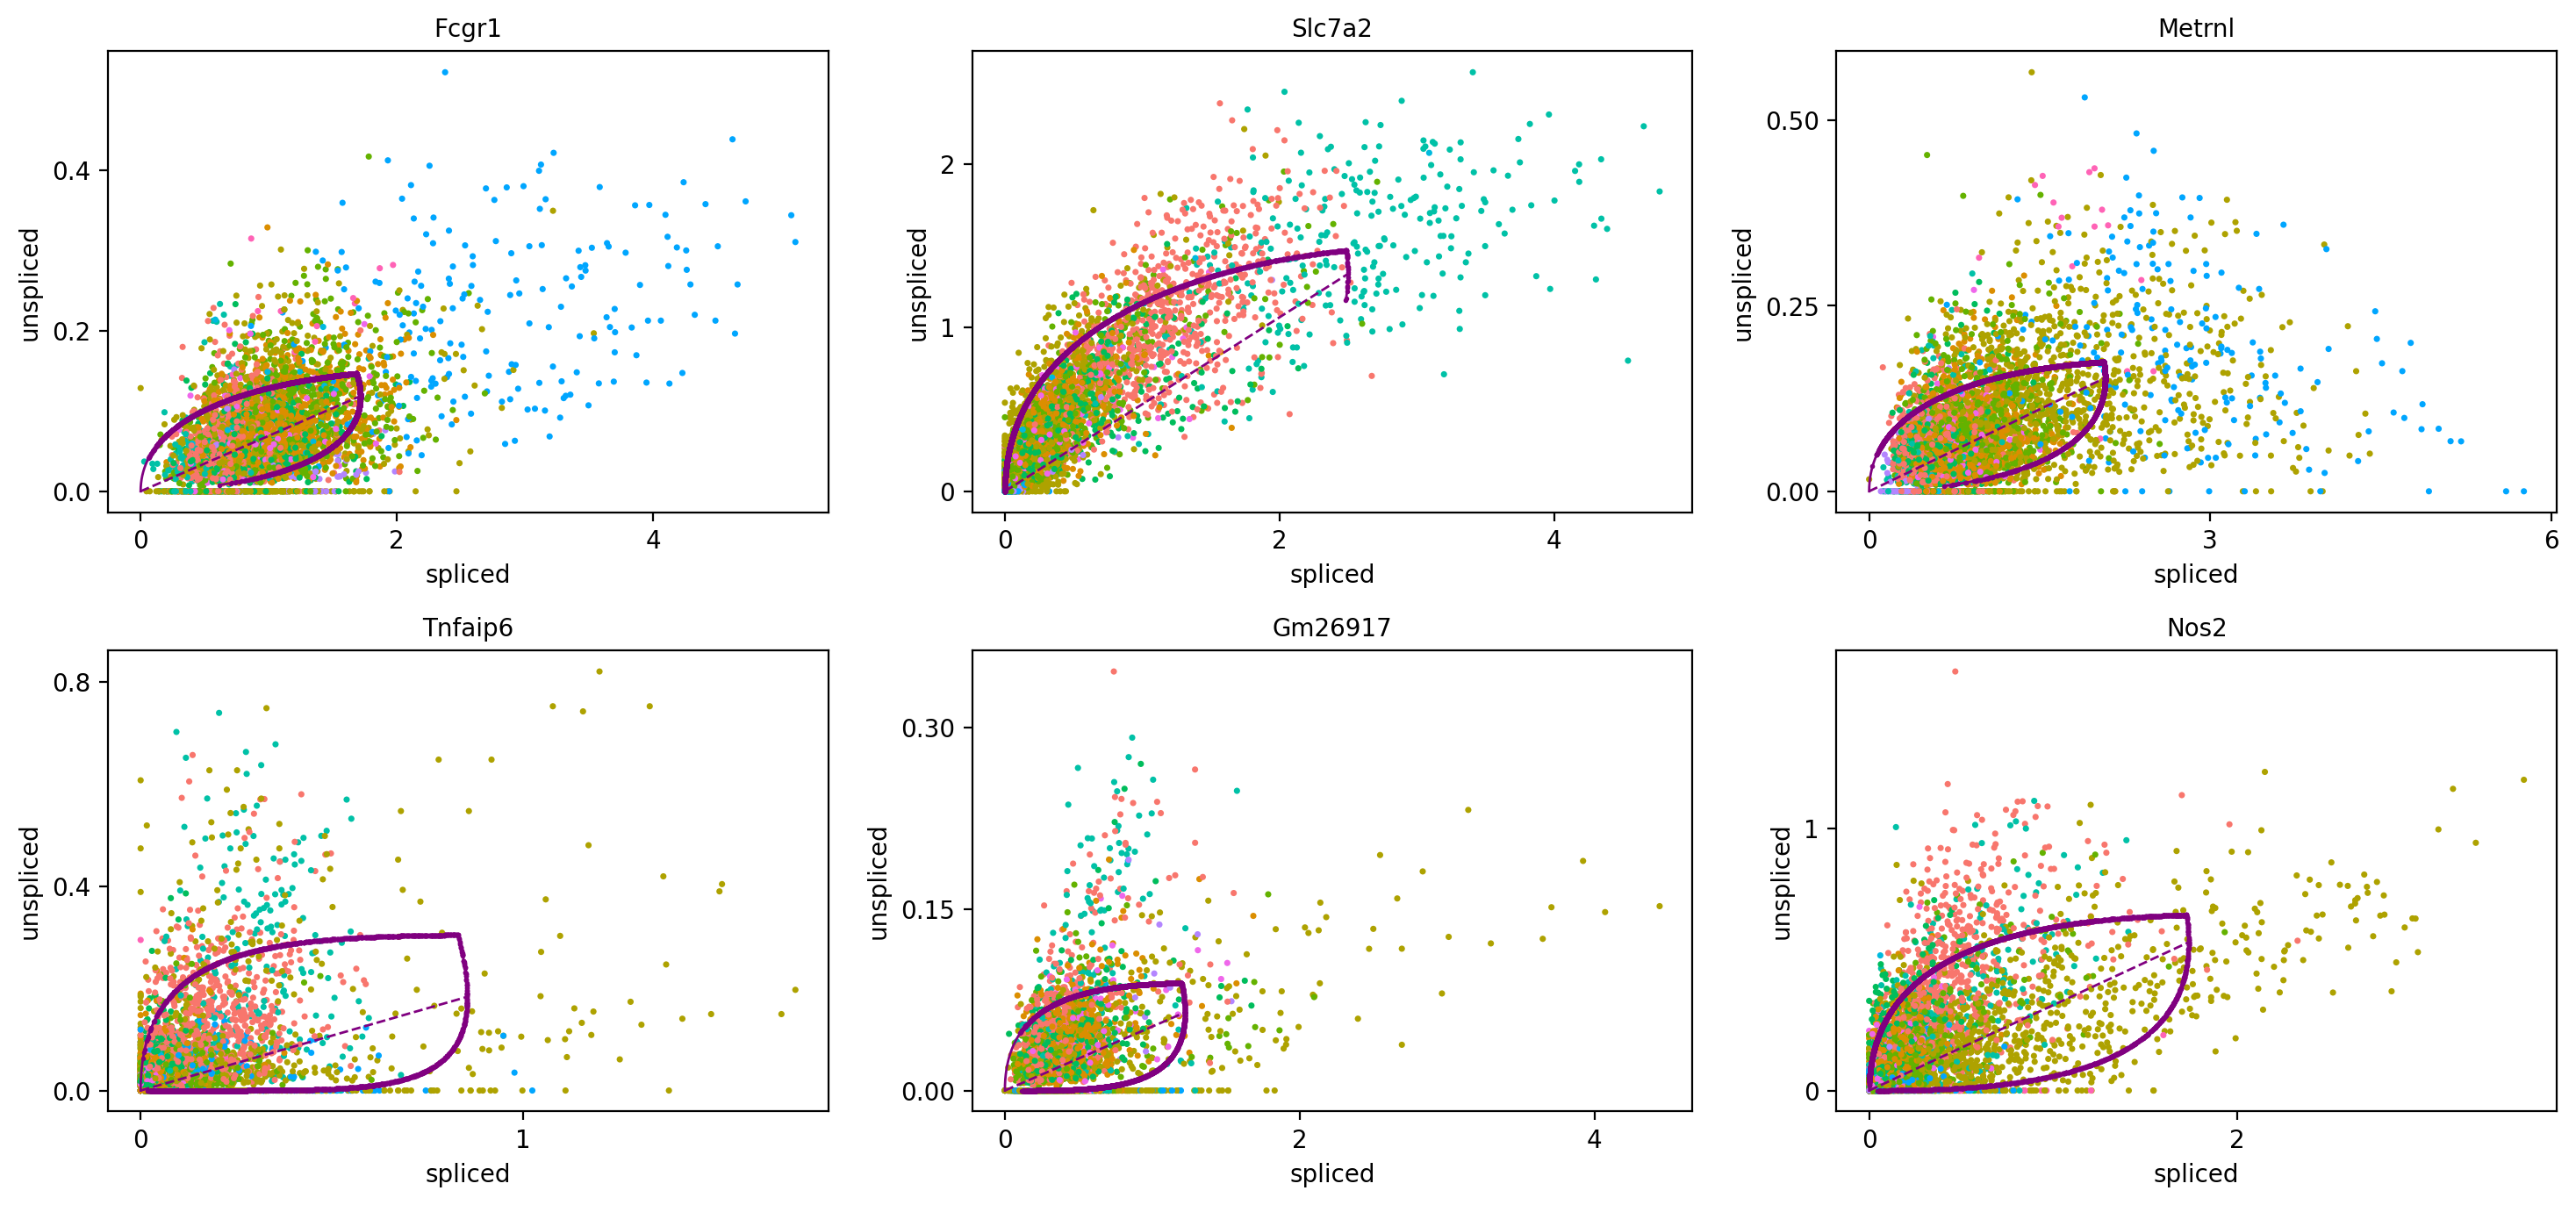

In [8]:
scv.pl.scatter(adata, df['0'][:6], ncols = 3, palette = clu_colors, dpi= 200)

# Velocity Confidence & Pseudotime

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


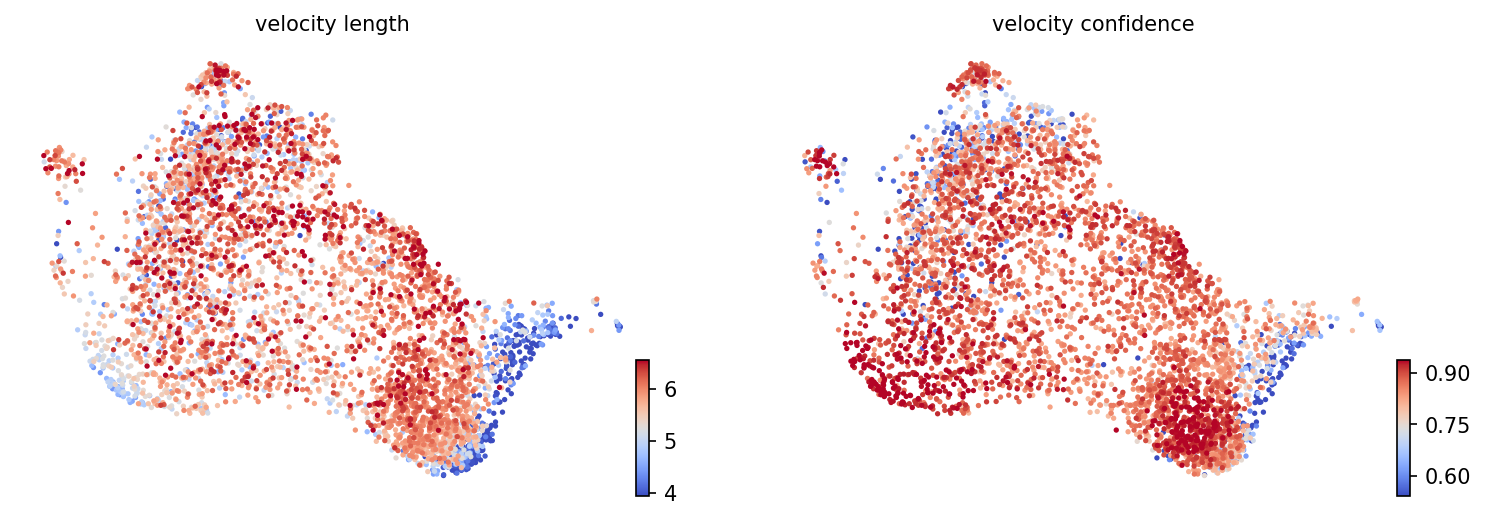

In [12]:
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95], dpi = 150)

In [13]:
df = adata.obs.groupby('clusters')[keys].mean().T
df.style.background_gradient(cmap='coolwarm', axis=1)

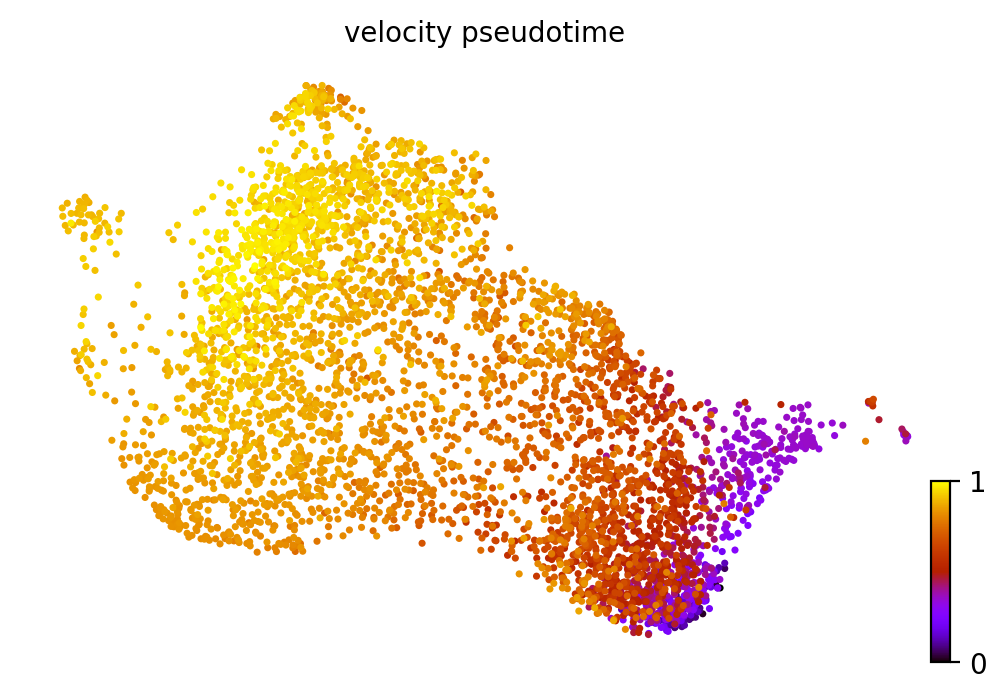

In [14]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot', dpi = 200)

# PAGA velocity graph

In [15]:
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']

In [16]:
scv.tl.paga(adata, groups='clusters')
df = scv.get_df(adata, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:02) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


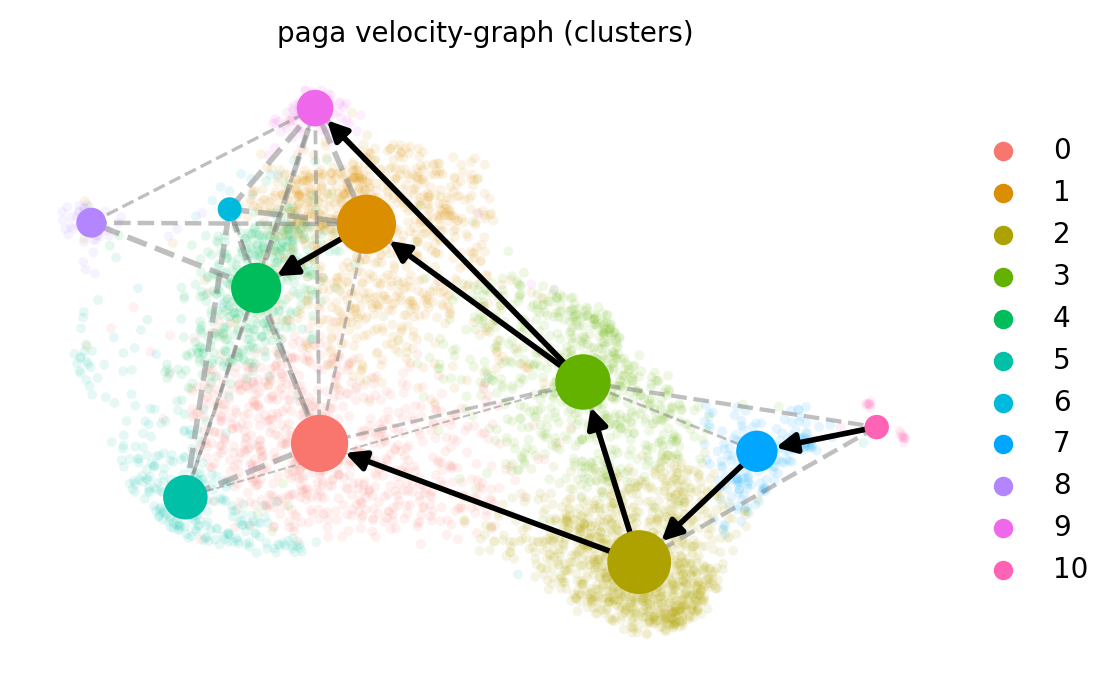

In [34]:
scv.pl.paga(adata, basis='umap', size=50, alpha=.1, threshold=0.2,
            min_edge_width=2, node_size_scale=1.5, dpi = 200)

# End